In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('../data/llm_predictions.parquet')
df = df[df['model'] == 'qwen2.5:0.5b']
comments_df =pd.read_parquet('../data/comments.parquet')
df = df.merge(
        comments_df[['id', 'rating', 'comment_length', 'pros_length_proportion', 'comment_length_group', 'pros_length_proportion_group']].rename(columns={'rating':'real_rating'}),
        on='id',
        how='inner'
    )
df['is_inconsistent'] = (
            (df['rating'] - df['real_rating'] > 1) |
            (df['rating'] - df['real_rating'] < -1)
            ).astype(int)

In [3]:
def select_llm_inconsistent_ids(model='qwen2.5:0.5b', llm_predictions_path='../data/llm_predictions.parquet'):
    df = pd.read_parquet(llm_predictions_path)
    df = df[df['model'] == model]
    df = df.merge(
        comments_df[['id', 'rating']].rename(columns={'rating':'real_rating'}),
        on='id',
        how='inner'
    )
    df['is_inconsistent'] = (
                (df['rating'] - df['real_rating'] > 1) |
                (df['rating'] - df['real_rating'] < -1)
                )
    df = df[df['is_inconsistent'] == True]
    return set(df['id'])
inconsistent_ids = select_llm_inconsistent_ids()
print(inconsistent_ids)

{'00f91ed9401dc53dcffb2bc1398a2adefbc67e53ce2fae39718733683839722f', '150c64600c27fc233f6f57e454d390fede16df57107c31de4bb8025b4e39d2d4', '89af52fffff4c1f69d43c4717822e1b6882110c9b20cdbdfeb92603511f0df14', '2e81981673864583b634975da242bf6642c691c53a6372a21f497a7476308e83', 'ac6562614ac823d8c42663a4f0c466dd65fb7df21909698c91f0e802dbdd7efc', 'dace7b86c3f32ba0aa4629e9d37aca2e9551fb8ede1b8e4052f8ba399bfe8a7e', 'b8e71ad8fe98a43394b82000f4f9b329d626ea23258a4ca749a181c2c60d4d67', '82fde121892c36b3f92e2304716552e81e437a081b76694699e9895b0f36dba4', '4420a33ef795b5533a0d75fffdff35904d535856dd66126ede8c51556d310161', 'c2908bccb409bb54899efaf9be95e0ff31e48951c257a3f5cd128c9bd4291a34', 'f6e259755499c2bcb62c950ee777b253e3c38b6293cee8896fccc933fd29ee0d', '7ae48148d248a8b234cad7b4a4bbadcb9e05bf5728ea19514e8f74137e98a386', 'bab26acbfbb47fb4ea9cfa45c5f4a8538b3f697ad8f15cda8aa4990a0ef7a41c', '8dde60aa46c2e0f266809eb885bc5c253f4ab0024228ff3a738abdc9f98ea904', '1099d27875a9d5943f36493311eee42f00a61a4a306b52

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14104 entries, 0 to 14103
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            14104 non-null  object        
 1   model                         14104 non-null  object        
 2   rating                        14104 non-null  int64         
 3   prediction_time               14104 non-null  float64       
 4   ts_prediction                 14104 non-null  datetime64[ns]
 5   extra_info                    14104 non-null  object        
 6   processing_time               14104 non-null  float64       
 7   real_rating                   14104 non-null  int64         
 8   comment_length                14104 non-null  int64         
 9   pros_length_proportion        14104 non-null  int64         
 10  comment_length_group          14104 non-null  int64         
 11  pros_length_proportion_group

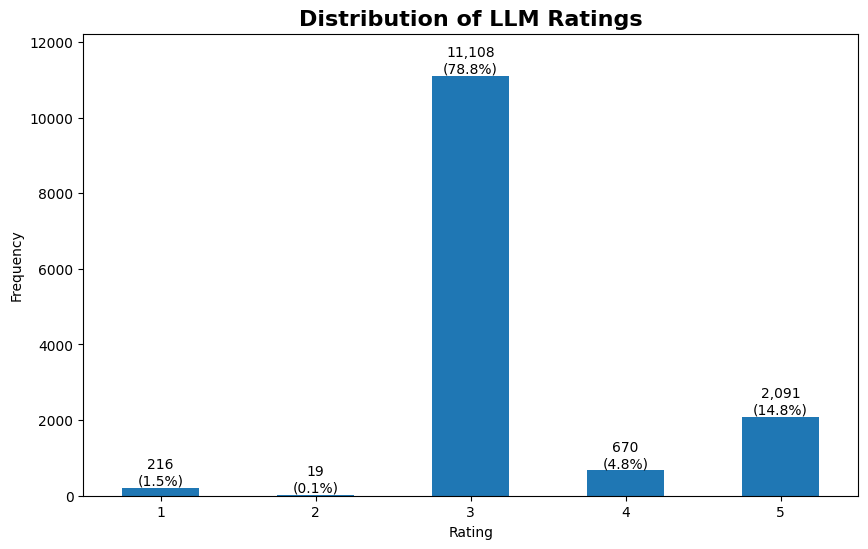

In [5]:
rating_counts = df['rating'].value_counts().sort_index()
total = rating_counts.sum()

plt.figure(figsize=(10, 6),)
ax = rating_counts.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of LLM Ratings', fontsize=16, fontweight='bold')
ax.set_ylim(0, rating_counts.max() * 1.1)

for i, count in enumerate(rating_counts):
    percentage = (count / total) * 100
    ax.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

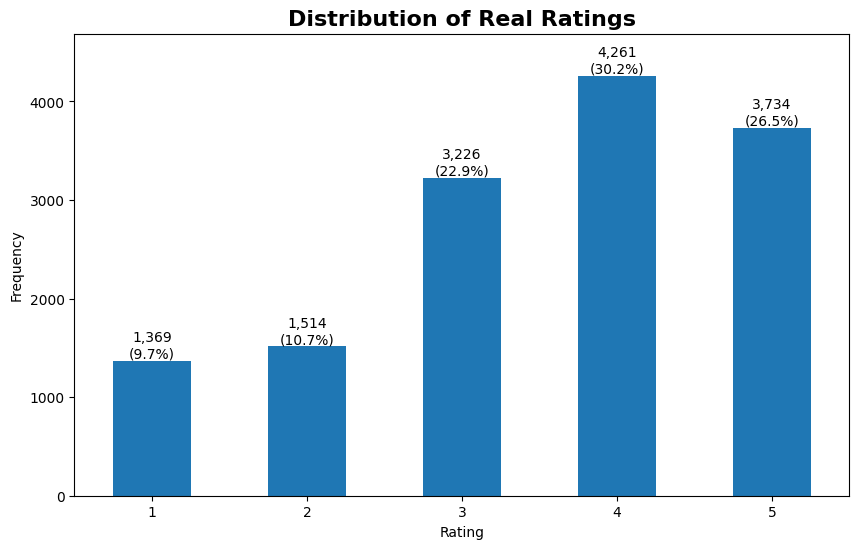

In [6]:
real_rating_counts = df['real_rating'].value_counts().sort_index()
total = real_rating_counts.sum()

plt.figure(figsize=(10, 6),)
ax = real_rating_counts.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Real Ratings', fontsize=16, fontweight='bold')
ax.set_ylim(0, real_rating_counts.max() * 1.1)

for i, count in enumerate(real_rating_counts):
    percentage = (count / total) * 100
    ax.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

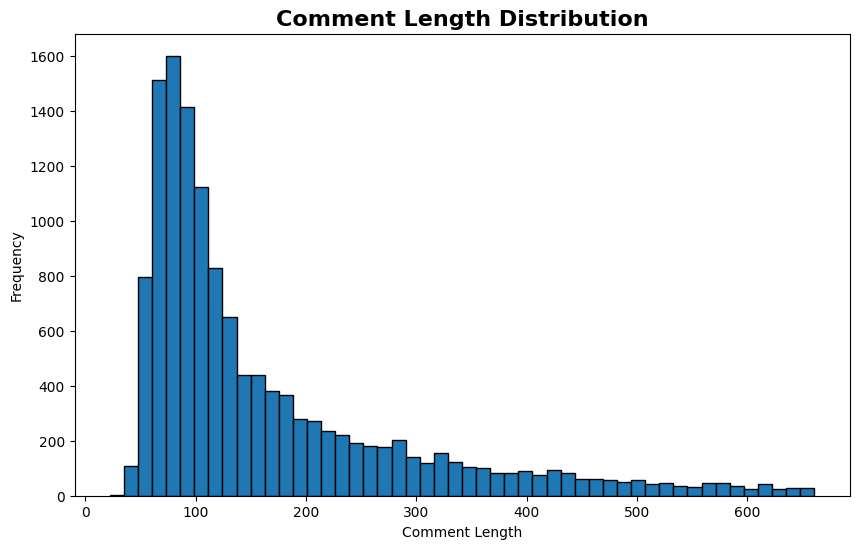

In [7]:
max_length = df['comment_length'].quantile(0.95)
filtered = df[df['comment_length'] <= max_length]

plt.figure(figsize=(10,6))
plt.hist(filtered['comment_length'], bins=50, edgecolor='black')
plt.title('Comment Length Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()

In [8]:
percentiles = df['comment_length'].quantile([0.2, 0.4, 0.6, 0.8]).reset_index()
percentiles.columns = ['Percentile', 'Comment Length']
display(percentiles)


,Percentile,Comment Length
0,0.2,76.0
1,0.4,101.0
2,0.6,149.0
3,0.8,282.0


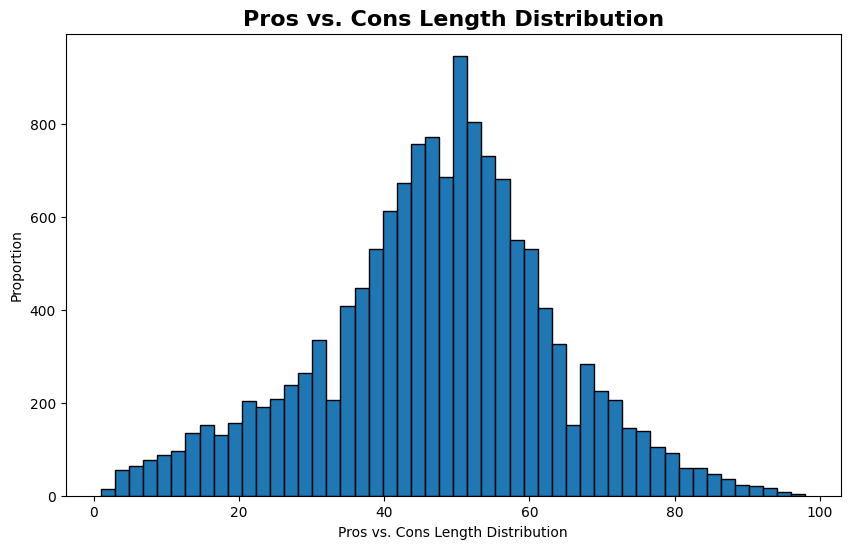

In [9]:
plt.figure(figsize=(10,6))
plt.hist(df['pros_length_proportion'], bins=50, edgecolor='black')
plt.title('Pros vs. Cons Length Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Pros vs. Cons Length Distribution')
plt.ylabel('Proportion')
plt.show()

In [10]:
percentiles = df['pros_length_proportion'].quantile([0.2, 0.4, 0.6, 0.8]).reset_index()
percentiles.columns = ['Percentile', 'Pros vs. Cons Length Distribution']
display(percentiles)


,Percentile,Pros vs. Cons Length Distribution
0,0.2,34.6
1,0.4,44.0
2,0.6,52.0
3,0.8,60.0


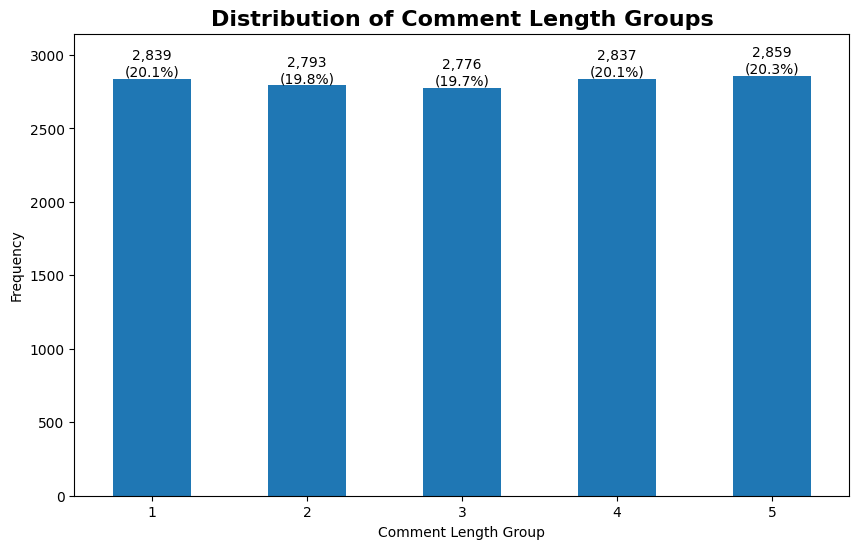

In [11]:
rating_counts = df['comment_length_group'].value_counts().sort_index()
total = rating_counts.sum()

plt.figure(figsize=(10, 6),)
ax = rating_counts.plot(kind='bar')
plt.xlabel('Comment Length Group')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Length Groups', fontsize=16, fontweight='bold')
ax.set_ylim(0, rating_counts.max() * 1.1)

for i, count in enumerate(rating_counts):
    percentage = (count / total) * 100
    ax.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

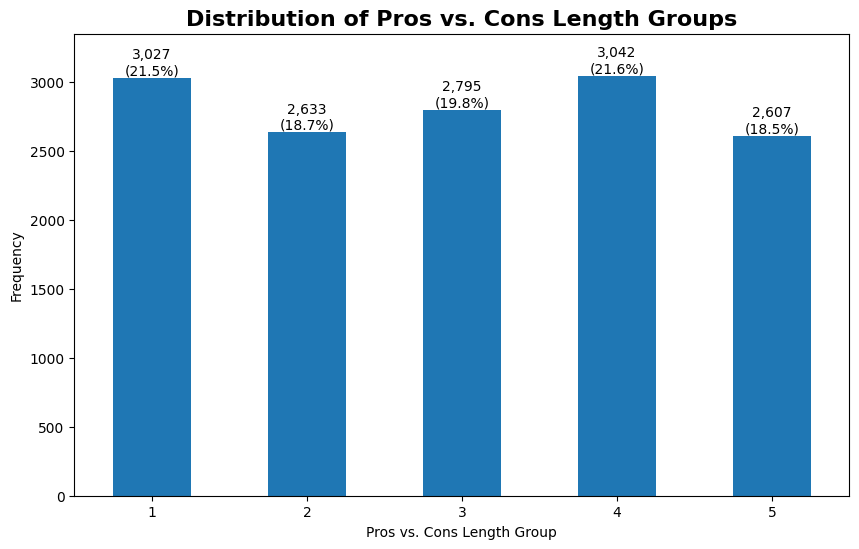

In [12]:
rating_counts = df['pros_length_proportion_group'].value_counts().sort_index()
total = rating_counts.sum()

plt.figure(figsize=(10, 6),)
ax = rating_counts.plot(kind='bar')
plt.xlabel('Pros vs. Cons Length Group')
plt.ylabel('Frequency')
plt.title('Distribution of Pros vs. Cons Length Groups', fontsize=16, fontweight='bold')
ax.set_ylim(0, rating_counts.max() * 1.1)

for i, count in enumerate(rating_counts):
    percentage = (count / total) * 100
    ax.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

In [13]:
cross_tab = pd.crosstab(df['comment_length_group'], df['pros_length_proportion_group'])
print(cross_tab)

pros_length_proportion_group     1    2    3    4    5
comment_length_group                                  
1                               85  607  855  913  379
2                              258  590  704  774  467
3                              518  561  489  584  624
4                              855  481  416  455  630
5                             1311  394  331  316  507


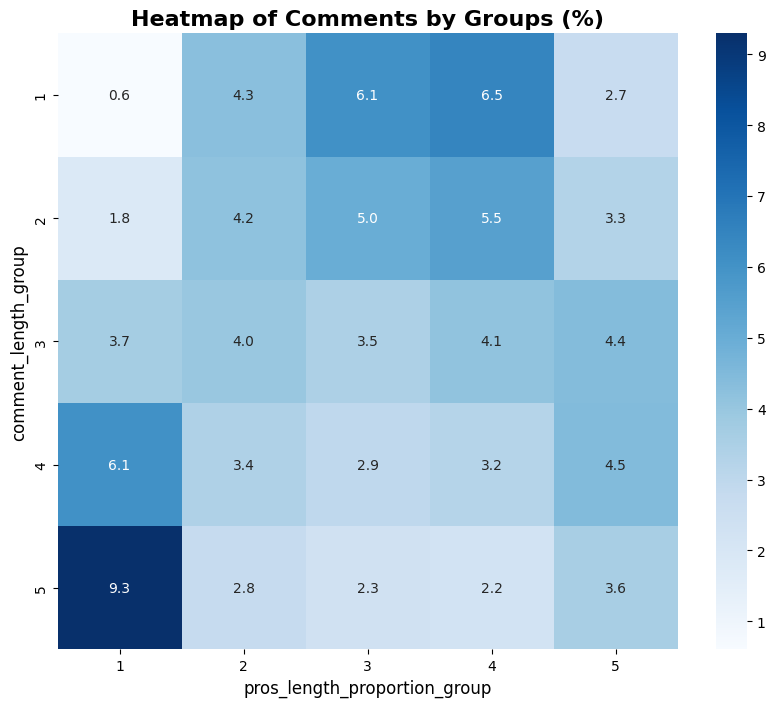

In [14]:
cross_tab = pd.crosstab(df['comment_length_group'], df['pros_length_proportion_group'])

# Calcula o total de comentários e converte as contagens em porcentagens
total_comments = cross_tab.values.sum()
cross_tab_percent = (cross_tab / total_comments) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab_percent, annot=True, fmt=".1f", cmap="Blues")
plt.title("Heatmap of Comments by Groups (%)", fontsize=16, fontweight="bold")
plt.xlabel("pros_length_proportion_group", fontsize=12)
plt.ylabel("comment_length_group", fontsize=12)
plt.show()

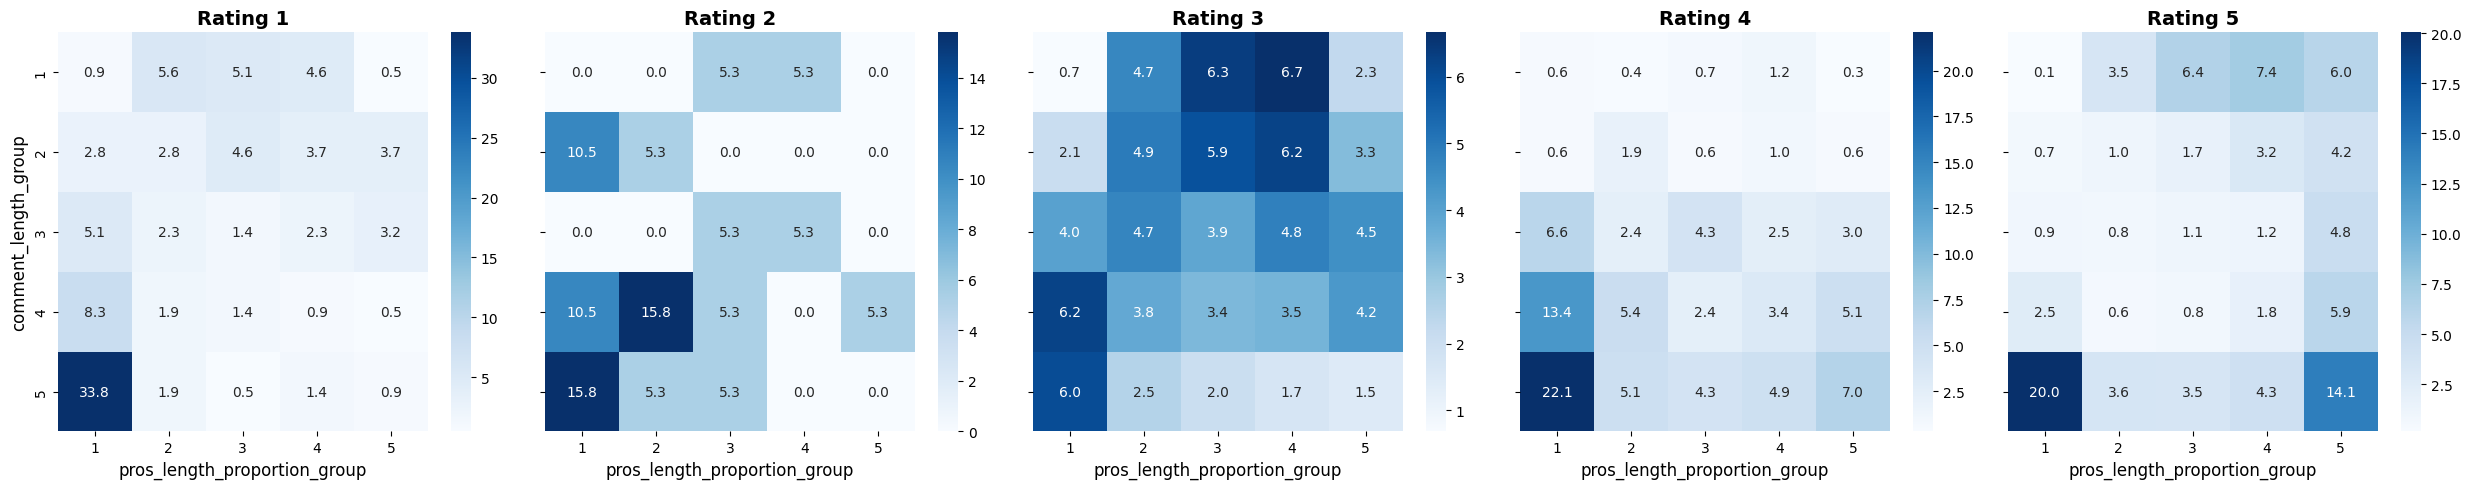

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

for rating in range(1, 6):
    # Filtra o DataFrame para o rating atual
    df_filtered = df[df['rating'] == rating]
    
    # Cria uma tabela cruzada com as contagens
    cross_tab = pd.crosstab(df_filtered['comment_length_group'], df_filtered['pros_length_proportion_group'])
    
    # Calcula o total de comentários para o rating filtrado
    total_comments = cross_tab.values.sum()
    
    # Converte as contagens em porcentagens (se houver comentários)
    if total_comments > 0:
        cross_tab_percent = (cross_tab / total_comments) * 100
    else:
        cross_tab_percent = cross_tab.copy()
    
    # Gera o heatmap no subplot correspondente
    sns.heatmap(cross_tab_percent, annot=True, fmt=".1f", cmap="Blues", ax=axes[rating-1])
    axes[rating-1].set_title(f'Rating {rating}', fontsize=14, fontweight='bold')
    axes[rating-1].set_xlabel("pros_length_proportion_group", fontsize=12)
    if rating == 1:
        axes[rating-1].set_ylabel("comment_length_group", fontsize=12)
    else:
        axes[rating-1].set_ylabel("")

plt.tight_layout()

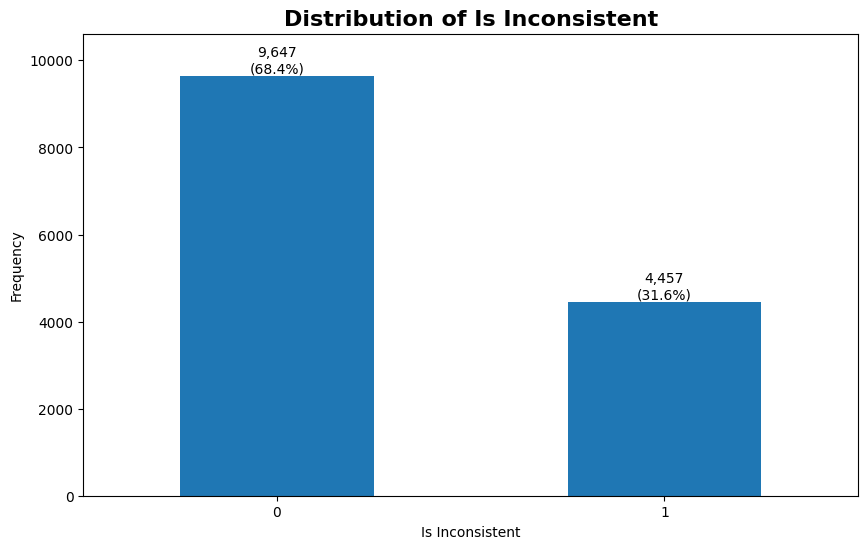

In [16]:
rating_counts = df['is_inconsistent'].value_counts().sort_index()
total = rating_counts.sum()

plt.figure(figsize=(10, 6),)
ax = rating_counts.plot(kind='bar')
plt.xlabel('Is Inconsistent')
plt.ylabel('Frequency')
plt.title('Distribution of Is Inconsistent', fontsize=16, fontweight='bold')
ax.set_ylim(0, rating_counts.max() * 1.1)

for i, count in enumerate(rating_counts):
    percentage = (count / total) * 100
    ax.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()